#### UNet architecture class

In [2]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        # Regularization to reduce overfitting
        self.dropout = nn.Dropout2d(p=0.5)
       
        # ENCODER
        # customize each layer of double conv
        self.down_conv_1 = self.doubleConv(1,64)
        self.down_conv_2 = self.doubleConv(64,128)
        self.down_conv_3 = self.doubleConv(128,256)
        self.down_conv_4 = self.doubleConv(256,512)
        self.down_conv_5 = self.doubleConv(512,1024)
        
        # DECODER
        self.up_conv_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(2,2), stride=(2,2))
        self.up_conv_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(2,2), stride=(2,2))
        self.up_conv_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(2,2), stride=(2,2))
        self.up_conv_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(2,2), stride=(2,2))
        
        self.down_conv_6 = self.doubleConv(1024,512)
        self.down_conv_7 = self.doubleConv(512,256)
        self.down_conv_8 = self.doubleConv(256,128)
        self.down_conv_9 = self.doubleConv(128,64)

        self.down_conv_final = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=(1,1))
        
    def doubleConv(self, in_c, out_c):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=(3,3)),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def cropping(self, ori_tensor, target_tensor):
        # assuming image is perfect square
        ori_tensor_width = ori_tensor.shape[3]
        target_tensor_width = target_tensor.shape[3]
        delta = ori_tensor_width - target_tensor_width
        delta = delta // 2 # assume perfect square
        return ori_tensor[:,:,delta:ori_tensor_width-delta, delta:ori_tensor_width-delta]
    
    def forward(self, x):
        # encoder
        x1 = self.down_conv_1(x)# output got concatenated
        x2 = self.maxpool(x1)
        x3 = self.down_conv_2(x2)# output got concatenated
        x4 = self.maxpool(x3)
        x5 = self.down_conv_3(x4)# output got concatenated
        x6 = self.maxpool(x5)
        x7 = self.down_conv_4(x6)# output got concatenated
        x8 = self.maxpool(x7)
        x9 = self.down_conv_5(x8)
        
        # decoder
        x10 = self.up_conv_1(x9)
        x10 = self.dropout(x10)
        x11 = torch.cat((x10,self.cropping(x7,x10)), dim=1)

        x12 = self.down_conv_6(x11)

        x13 = self.up_conv_2(x12)
        x13 = self.dropout(x13)
        x14 = torch.cat((x13,self.cropping(x5,x13)), dim=1)

        x15 = self.down_conv_7(x14)

        x16 = self.up_conv_3(x15)
        x16 = self.dropout(x16)
        x17 = torch.cat((x16,self.cropping(x3,x16)), dim=1)

        x18 = self.down_conv_8(x17)

        x19 = self.up_conv_4(x18)
        x19 = self.dropout(x19)
        x20 = torch.cat((x19,self.cropping(x1,x19)), dim=1)

        x21 = self.down_conv_9(x20)

        x22 = self.down_conv_final(x21)
        return x22
        
        

#### MultiInputNet architecture class

In [3]:
class MultiInputNet(nn.Module):
    def __init__(self, landmark_input_size=64, landmark_output_size=64):
        super().__init__()
        
        # image pathway (Dense UNet)
        self.u_net = UNet()
        self.u_net = self.u_net.to(device)
        
        # landmark pathway
        self.landmark_input_size = landmark_input_size
        self.landmark_output_size = landmark_output_size
        self.landmark_fc = nn.Linear(self.landmark_input_size, self.landmark_output_size)
        
        # combined pathway
        # based on (c,h,w), output unet is (2,388,388) and output landmarks ffn is (1,1,64)  
        combined_input = 2*388*388 + 1*64
        self.combined_fc = nn.Linear(combined_input, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 3)
        
        # dropout feed forward for regularization
        self.dropout = nn.Dropout(0.2)  # Dropout layer with dropout rate of 0.5

        # activation fn
        self.relu = nn.ReLU()
    
    def forward(self, image, landmark):
        # unet process
        image_features = self.u_net(image)
        # landmark process
        landmark_features = self.landmark_fc(landmark)
        
        # combined features
        # img_b4_flat = image_features
        # land_b4_flat = landmark_features
        # print("Image before flatten ", img_b4_flat.shape)
        # print("landmark before flatten ", land_b4_flat.shape)
        
        # flatten both tensor before concatenating, exclude batch_size in BCHW, only flatten CHW
        flatten_img = torch.flatten(image_features, start_dim=1) 
        flatten_land = torch.flatten(landmark_features, start_dim=1)
        
        # print("Image after flatten ", flatten_img.shape)
        # print("landmark after flatten ", flatten_land.shape)

        combined_features = torch.cat((flatten_img,flatten_land), dim=1)
        # print("Combined_features ", combined_features.shape)
        
        x = self.combined_fc(combined_features)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

#### Define cuda

In [4]:
# Move the model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Import training and test dataset from .csv

In [5]:
import pandas as pd
import time

In [6]:
# Load training data
dataset_training_csv_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\training_dataset\\angles_ap_labelled_training.csv'
dataset_training_csv = pd.read_csv(dataset_training_csv_path)
dataset_training_csv

,PT,MT,TL/L,image_training_file,cobb_angle_training_file
0,6.2069,0.00000,1.261400,sunhl-1th-02-Jan-2017-162 A AP.jpg,sunhl-1th-02-Jan-2017-162 A AP.jpg.mat
1,23.8107,0.00000,0.851886,sunhl-1th-02-Jan-2017-162 B AP.jpg,sunhl-1th-02-Jan-2017-162 B AP.jpg.mat
2,21.1172,0.00000,0.000000,sunhl-1th-03-Jan-2017-163 A AP.jpg,sunhl-1th-03-Jan-2017-163 A AP.jpg.mat
3,10.8144,8.60388,0.000000,sunhl-1th-03-Jan-2017-163 B AP.jpg,sunhl-1th-03-Jan-2017-163 B AP.jpg.mat
4,18.1538,0.00000,1.748480,sunhl-1th-03-Jan-2017-164 A AP.jpg,sunhl-1th-03-Jan-2017-164 A AP.jpg.mat
...,...,...,...,...,...
476,12.5325,0.00000,11.484000,sunhl-1th-30-Dec-2016-159 A AP2.jpg,sunhl-1th-30-Dec-2016-159 A AP2.jpg.mat
477,11.0118,10.37890,0.000000,sunhl-1th-30-Dec-2016-159 B AP.jpg,sunhl-1th-30-Dec-2016-159 B AP.jpg.mat
478,5.6424,3.95370,2.821400,sunhl-1th-30-Dec-2016-159 C AP.jpg,sunhl-1th-30-Dec-2016-159 C AP.jpg.mat
479,16.3437,0.00000,0.000000,sunhl-1th-30-Dec-2016-160 A AP.jpg,sunhl-1th-30-Dec-2016-160 A AP.jpg.mat


In [7]:
# Load test data
dataset_test_csv_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\test_dataset\\angles_ap_labelled_test.csv'
dataset_test_csv = pd.read_csv(dataset_test_csv_path)
dataset_test_csv

,PT,MT,TL/L,image_test_file,cobb_angle_test_file
0,12.5578,0.00000,0.938543,sunhl-1th-01-Mar-2017-310 C AP.jpg,sunhl-1th-01-Mar-2017-310 C AP.jpg.mat
1,7.4942,1.00940,0.000000,sunhl-1th-01-Mar-2017-310 a ap.jpg,sunhl-1th-01-Mar-2017-310 a ap.jpg.mat
2,14.0048,0.00000,0.501069,sunhl-1th-01-Mar-2017-311 A AP.jpg,sunhl-1th-01-Mar-2017-311 A AP.jpg.mat
3,13.3802,0.00000,1.422200,sunhl-1th-01-Mar-2017-311 C AP.jpg,sunhl-1th-01-Mar-2017-311 C AP.jpg.mat
4,16.1798,1.23238,0.000000,sunhl-1th-01-Mar-2017-311 D AP.jpg,sunhl-1th-01-Mar-2017-311 D AP.jpg.mat
...,...,...,...,...,...
123,7.8933,0.00000,1.726000,sunhl-1th-28-Feb-2017-307 B AP.jpg,sunhl-1th-28-Feb-2017-307 B AP.jpg.mat
124,22.5108,0.00000,14.726900,sunhl-1th-28-Feb-2017-308 A AP.jpg,sunhl-1th-28-Feb-2017-308 A AP.jpg.mat
125,9.3330,0.73155,6.376700,sunhl-1th-28-Feb-2017-309 A AP.jpg,sunhl-1th-28-Feb-2017-309 A AP.jpg.mat
126,17.5526,8.90332,1.856840,sunhl-1th-28-Feb-2017-309 B AP.jpg,sunhl-1th-28-Feb-2017-309 B AP.jpg.mat


#### Prepare dictionary for training image data and its Cobb angle

In [7]:
training_dataset_dict = {} # good approach to maintain image - target_angle relation

# get train image list and its path
training_image_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\data\\training\\'

# get list of keys ie filepath
training_image_filepath_key = dataset_training_csv['image_training_file'].values.tolist()

# get list of values for dict
training_cobb_angle_values = dataset_training_csv[['PT', 'MT', 'TL/L']].values

# add to dictionary
for i in range(len(training_image_filepath_key)):
    training_dataset_dict[training_image_path + training_image_filepath_key[i]] = torch.tensor(training_cobb_angle_values[i], dtype=torch.float32)

#### Prepare dictionary for test image data and its Cobb angle

In [8]:
test_dataset_dict = {}
test_image_path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\data\\test\\'
test_image_filepath_key = dataset_test_csv['image_test_file'].values.tolist()
test_cobb_angle_values = dataset_test_csv[['PT', 'MT', 'TL/L']].values

for i in range(len(test_image_filepath_key)):
    test_dataset_dict[test_image_path + test_image_filepath_key[i]] = torch.tensor(test_cobb_angle_values[i], dtype=torch.float32)

#### Prepare dictionary for training landmarks_ap

In [9]:
path_landmark_ap_training = "C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\training_dataset\\"
landmark_ap_training = pd.read_csv(path_landmark_ap_training + "landmarks_ap.csv", header=None)
training_landmark_ap_key = landmark_ap_training.iloc[:,0].values.tolist()
training_landmark_ap_values = landmark_ap_training.iloc[:,2:].values.tolist()


In [10]:
training_landmark_ap_dict = {} # key->image filepath, value->62 landmarks value

for i in range(len(training_landmark_ap_key)):
    training_landmark_ap_dict[training_image_path + training_landmark_ap_key[i]] = torch.tensor(training_landmark_ap_values[i], dtype=torch.float32)

#### Prepare dictionary for test landmarks_ap

In [15]:
path_landmark_ap_test = "C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\test_dataset\\"
landmark_ap_test = pd.read_csv(path_landmark_ap_test + "landmarks_ap.csv", header=None)
test_landmark_ap_key = landmark_ap_test.iloc[:,0].values.tolist()
test_landmark_ap_values = landmark_ap_test.iloc[:,2:].values.tolist()


In [16]:
test_landmark_ap_dict = {} # key->image filepath, value->62 landmarks value

for i in range(len(test_landmark_ap_key)):
    test_landmark_ap_dict[test_image_path + test_landmark_ap_key[i]] = torch.tensor(test_landmark_ap_values[i], dtype=torch.float32)

#### CustomDataset class

In [11]:
from torch.utils.data import Dataset
from PIL import Image, ImageOps
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import numpy as np

In [12]:
# create dictionary dataset where key is image path and value is PT, MT, TL/L values
class CustomDataset(Dataset):
    def __init__(self, image_list, landmark_list, cobb_angle_list, transform_image_tensor, custom_img_resize_w_h=(255,255)):
        self.images = image_list
        # convert python list of torch.tensor to torch tensor
        self.landmarks = torch.stack(landmark_list, dim=0) 
        self.cobb_angles = torch.stack(cobb_angle_list, dim=0) 
        self.transform_image_tensor = transform_image_tensor
        self.custom_img_resize_w_h = custom_img_resize_w_h
        self.mean_img = 0.0
        self.std_img = 0.0
        self.mean_cobb_angle = 0.0
        self.std_cobb_angle = 0.0
        self.mean_landmark = 0.0
        self.std_landmark = 0.0
        
        self.calculate_mean_std_img()
        self.calculate_mean_std_cobb_angle()
        self.calculate_mean_std_landmark()

        # normalize dataset once
        self.cobb_angles = (self.cobb_angles - self.mean_cobb_angle)/self.std_cobb_angle
        self.landmarks = (self.landmarks - self.mean_landmark)/self.std_landmark

        
    def __getitem__(self, index):
        image_path = self.images[index] # image_path is the key
        
        image = Image.open(image_path).convert('L')
        
        # custom resize image while maintaining aspect ratio
        image = self.resize_with_padding(image, self.custom_img_resize_w_h)
        
        # calculate mean and std of entire images
        z_norm_img = transforms.Normalize(self.mean_img, self.std_img)
        
        # transform image if required
        if self.transform_image_tensor is not None:
            image = self.transform_image_tensor(image)
            image = torch.permute(image, dims=(0,2,1)) # convert PIL (w,h) to tensor (h,w)
            image = z_norm_img(image)
            
        # transform ie normalize cobb_angle
        # z_norm_cobb_angle = transforms.Normalize(self.mean_cobb_angle, self.std_cobb_angle)
        # self.cobb_angles = z_norm_cobb_angle(self.cobb_angles)
        # self.cobb_angles = (self.cobb_angles - self.mean_cobb_angle)/self.std_cobb_angle
        
        # transform ie normalize landmark
        # z_norm_landmark = transforms.Normalize(self.mean_landmark, self.std_landmark)
        # self.landmark = z_norm_landmark(self.landmarks)
        # self.landmarks = (self.landmarks - self.mean_landmark)/self.std_landmark
        

        # because U-net is hardcoded for 3 channel, duplicate another 2 channel
        # image = torch.cat((image[:,:,:], image[:,:,:], image[:,:,:]), dim=0)
        
        return image, self.landmarks[index], self.cobb_angles[index], image_path
    
    def __len__(self):
        return len(self.images)
    
    def resize_with_padding(self, image, output_size):
        original_width, original_height = image.size
        target_width, target_height = output_size

        # Calculate aspect ratios
        aspect_ratio = original_width / original_height
        target_ratio = target_width / target_height

        # Calculate the new dimensions while maintaining aspect ratio
        if aspect_ratio > target_ratio:
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_height
            new_width = int(new_height * aspect_ratio)

        # Resize the image while preserving the aspect ratio
        resized_image = image.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)

        # Create a new image with the target size and paste the resized image onto it
        padded_image = Image.new('L', (target_width, target_height))
        x_offset = (target_width - new_width) // 2
        y_offset = (target_height - new_height) // 2
        padded_image.paste(resized_image, (x_offset, y_offset))

        return padded_image
    
    def calculate_mean_std_img(self):
        num_images = len(self.images)
        mean_list = np.zeros((num_images,))
        std_list = np.zeros((num_images,))
        
        for i in range(num_images):
            image_path = self.images[i]
            image = Image.open(image_path).convert('L')
            image = self.resize_with_padding(image, self.custom_img_resize_w_h)
            
            image_tensor = ToTensor()(image)
            image_tensor = torch.permute(image_tensor, dims=(0,2,1)) # convert PIL (w,h) to tensor (h,w)
            
            mean_list[i] = torch.mean(image_tensor)
            std_list[i] = torch.std(image_tensor)

        # calculate combined std
        var_list = np.array([element**2 for element in std_list])
        combined_std = np.sqrt(np.sum(var_list)/std_list.shape[0])
        self.std_img = combined_std # result output
        
        # calculate combined mean
        combined_mean = np.mean(mean_list)
        self.mean_img = combined_mean # result output
        
    def calculate_mean_std_cobb_angle(self):
        num_cobb_angle = self.cobb_angles.shape[0]
        PT_values_list = np.zeros((num_cobb_angle,))
        MT_values_list = np.zeros((num_cobb_angle,))
        TL_values_list = np.zeros((num_cobb_angle,))
        
        
        for i in range(num_cobb_angle):
            PT_values_list[i] = self.cobb_angles[i][0]
            MT_values_list[i] = self.cobb_angles[i][1]
            TL_values_list[i] = self.cobb_angles[i][2]
            
        
        PT_mean = np.mean(PT_values_list)
        MT_mean = np.mean(MT_values_list)
        TL_mean = np.mean(TL_values_list)
        
        PT_std = np.std(PT_values_list)
        MT_std = np.std(MT_values_list)
        TL_std = np.std(TL_values_list)
        
        #calculate combined std
        var_list = np.array([PT_std**2, MT_std**2, TL_std**2])
        combined_std = np.sqrt(np.sum(var_list)/3)
        self.std_cobb_angle = combined_std
        
        # calculate combined mean
        combined_mean = np.mean([PT_mean,MT_mean,TL_mean])
        self.mean_cobb_angle = combined_mean
        
        print('std_cobb_angle ', combined_std)
        print('mean_cobb_angle ', combined_mean)
        
    def calculate_mean_std_landmark(self):
        # torch_landmark = torch.stack(self.landmarks, dim=0) # convert list to tensor
        mean_list = torch.mean(self.landmarks, dim=0) # row collapse to calculate each column mean
        std_list = torch.std(self.landmarks, dim=0) # row collapse to calculate each column std
        
        # calculate combined std
        var_list = torch.tensor([element**2 for element in std_list])
        combined_std = torch.sqrt(torch.sum(var_list)/std_list.shape[0])
        self.std_landmark = combined_std
        
        # calculate combined mean
        combined_mean = torch.mean(mean_list)
        self.mean_landmark = combined_mean

#### Tensor Transformations

In [15]:
# # calculate mean and standard deviation for entire image_dataset

# import numpy as np
# # open all training images and put them in 1 numpy block
# all_images_path = list(training_dataset_dict.keys())
# images_training = np.zeros((len(all_images_path,)), dtype=object)

# for i in range(len(all_images_path)):
#     img = Image.open(all_images_path[i]).convert('L')
#     images_training[i] = np.asarray(img, dtype=np.float32)
    
# # print(images)

# mean_training = np.mean(images_training)
# std_training = np.std(images_training)

# print('mean is ', mean_training)
# print('std is ', std_training)

In [13]:
transform_images_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.type(torch.float32))
])

#### Train-Validation split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# transform to list before inputting into splitting function
training_image_list = list(training_dataset_dict.keys())
training_landmark_list = list(training_landmark_ap_dict.values())
training_true_cobb_angle_list = list(training_dataset_dict.values())

In [19]:
# Split the lists into training and validation sets
training_image, val_image, training_landmark, val_landmark, training_true_cobb_angle, val_true_cobb_angle = train_test_split(training_image_list, training_landmark_list, training_true_cobb_angle_list, test_size=0.2, random_state=42)

#### Custom Dataset instance for training and validation

In [21]:
print('transformed_training_dataset')
transformed_training_dataset = CustomDataset(training_image, training_landmark, training_true_cobb_angle, transform_images_tensor, (572,572))
print('transformed_validation_dataset')
transformed_validation_dataset = CustomDataset(val_image, val_landmark, val_true_cobb_angle, transform_images_tensor, (572,572))

transformed_training_dataset


NameError: name 'training_image' is not defined

In [21]:
# _, landmark, cobb, path = transformed_training_dataset.__getitem__(2)
# print('cobb ', cobb)
# print('imgfile ', path)

#### training_loader and validation_loader

In [20]:
from torch.utils.data import DataLoader
# Create a data loader for batching and shuffling the data
# batch_size = 32

training_loader = DataLoader(transformed_training_dataset, batch_size=4, shuffle=True)
validation_loader =  DataLoader(transformed_validation_dataset, batch_size=1, shuffle=False)

NameError: name 'transformed_training_dataset' is not defined

In [23]:
# # scractcpad
# model_try = MultiInputNet(landmark_input_size=64, landmark_output_size=64)
# model_try.to(device)
# for img, land, target, imagepath in training_loader:
#     img = img.to(device)
#     land = land.to(device)
#     target = target.to(device)
#     print('imagepath ', imagepath)
#     print('target angle ', target)
#     predicted = model_try(img, land)
#     print('predicted ', predicted)

#### Training and validating process

In [26]:
import torch.optim as optim

In [28]:
model = MultiInputNet(landmark_input_size=64, landmark_output_size=64)
model = model.to(device)

In [29]:
# set up optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

In [27]:
# to save validation loss and training loss
loss_list_data = []

# to keep track lowest loss
lowest_val_loss = float('inf')

start_time = time.time()

# training loop with validation
for epoch in range(num_epochs):
    
    # training phase
    model.train()                                       # allow weights and biases adjusting
    training_loss = 0.0
    for image_input, landmark_input, target_angle, _ in training_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        # reshape target_angle
        # target_angle = target_angle.reshape((3))
        target_angle = target_angle.to(device)
        optimizer.zero_grad()                           # clearing previous loss derivative
        predicted = model(image_input, landmark_input)                  # forward 
        loss = criterion(predicted, target_angle)       # computing loss
        loss.backward()                                 # computing loss derivative with respect of weights and biases
        optimizer.step()                                # adjusting weights and biases
        training_loss += loss.item()                    # summing all batches losses for averaging
    training_loss /= len(training_loader)
        
    # validation phase in at end of every epoch
    model.eval()                                        # block weights and biases adjsuting
    val_loss = 0.0
    with torch.no_grad():                                # remove all computed derivatives
        for image_input, landmark_input, target_angle, _ in validation_loader:
            # move input and output to cuda if available
            image_input = image_input.to(device)
            landmark_input = landmark_input.to(device)
            # reshape target_angle
            # target_angle = target_angle.reshape((3))
            target_angle = target_angle.to(device)
            predicted = model(image_input, landmark_input)
            # for averaging validation loss
            val_loss += criterion(predicted, target_angle).item()
    
    val_loss /= len(validation_loader) # calculating average validation loss
    
    # Print the training and validation loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss}, Validation Loss: {val_loss}")    
    
    # for graphing evaluation later
    loss_list_data.append((epoch+1, training_loss, val_loss))
    
    # save best model with lowest validation loss
    if lowest_val_loss > val_loss:
        lowest_val_loss = val_loss
        best_model = model.state_dict()
        print('Lowest val_loss found')


end_time = time.time()

# save the best model found
path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\saved_models\\training_6\\'
torch.save(best_model, path + 'best_training_6.pt')

Epoch [1/100], Training Loss: 173.8056557221959, Validation Loss: 1.0845439811957251
Lowest val_loss found
Epoch [2/100], Training Loss: 1.5463003764549892, Validation Loss: 1.0482048229362393
Lowest val_loss found
Epoch [3/100], Training Loss: 1.2822788426031668, Validation Loss: 1.0740460051396459
Epoch [4/100], Training Loss: 1.2489183366609116, Validation Loss: 1.0336959296789443
Lowest val_loss found
Epoch [5/100], Training Loss: 1.2294196498890717, Validation Loss: 1.0327821271398019
Lowest val_loss found
Epoch [6/100], Training Loss: 1.185493697412312, Validation Loss: 1.0900582499494873
Epoch [7/100], Training Loss: 1.0933784629839163, Validation Loss: 1.0037261929708658
Lowest val_loss found
Epoch [8/100], Training Loss: 1.1086308020167053, Validation Loss: 1.0176351045056717
Epoch [9/100], Training Loss: 1.06015180144459, Validation Loss: 1.0833189895895032
Epoch [10/100], Training Loss: 1.0183847804243367, Validation Loss: 1.0494927194775994
Epoch [11/100], Training Loss: 1.

#### Compute training time

In [28]:
training_time = end_time - start_time
print("Training time elapsed: " + str(training_time) + " seconds")

Training time elapsed: 10031.348716974258 seconds


#### Save latest model

In [29]:
# save model 
path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\saved_models\\training_6\\'
torch.save(model.state_dict(), path + 'finished_training_6.pt')

#### Testing model

In [17]:
# unpack list
test_image = list(test_dataset_dict.keys())
test_true_cobb_angle = list(test_dataset_dict.values())
test_landmark = list(test_landmark_ap_dict.values())

In [18]:
# loading test dataset
transformed_test_dataset = CustomDataset(test_image, test_landmark, test_true_cobb_angle, transform_images_tensor, (572,572))

std_cobb_angle  2.988889043938208
mean_cobb_angle  5.054406259208918


In [22]:
# testing data loader
test_loader =  DataLoader(transformed_test_dataset, batch_size=1, shuffle=False)

In [33]:
test_loss = 0.0
model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        # reshape target_angle
        # target_angle = target_angle.reshape((3))
        target_angle = target_angle.to(device)
        predicted = model(image_input, landmark_input)
        test_loss += criterion(predicted, target_angle).item()

test_loss /= len(test_loader) # calculating average test_loss
print(f"Final model testing loss: {test_loss}")

Final model testing loss: 1.179789298970718


In [31]:
# load best model
path = 'C:\\Users\\iqmal_pc\\Desktop\\fyp_experiment\\saved_models\\training_6\\'

the_best_model = MultiInputNet(landmark_input_size=64, landmark_output_size=64)
the_best_model.load_state_dict(torch.load(path + 'best_training_6.pt')) # load the saved best model weights & biases dictionary
the_best_model = the_best_model.to(device)
# testing phase using best model
test_loss = 0.0
the_best_model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        target_angle = target_angle.to(device)
        predicted = the_best_model(image_input, landmark_input)
        test_loss += criterion(predicted, target_angle).item()

test_loss /= len(test_loader) # calculating average test_loss
print(f"Best model testing loss: {test_loss}")

Best model testing loss: 1.179789298970718


#### Evaluation (Loss vs Epoch)

In [35]:
epoch_list = []
training_loss_list = []
validation_loss_list = []

for i in range(len(loss_list_data)):
    epoch_list.append(loss_list_data[i][0])
    training_loss_list.append(loss_list_data[i][1])
    validation_loss_list.append(loss_list_data[i][2])

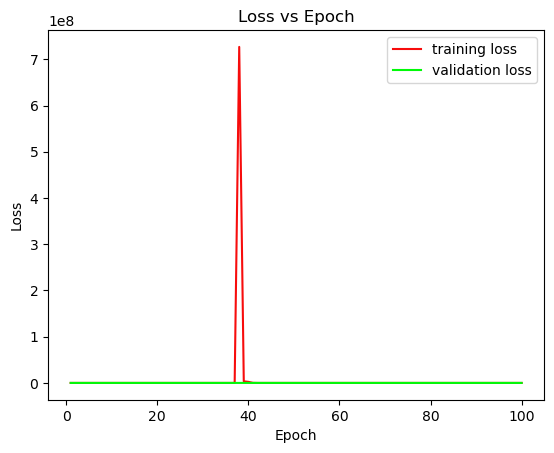

In [36]:
# plot training loss vs epoch
import matplotlib.pyplot as plt

plt.plot(epoch_list, training_loss_list, color='#f70c0c', label='training loss')
plt.plot(epoch_list, validation_loss_list, color='#00fa08', label='validation loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Test data evaluation plot (Predicted vs Ground Truth) for every PT, MT and TL/L

In [32]:
predicted_list = []
target_angle_list = []

the_best_model.eval()
with torch.no_grad():
    for image_input, landmark_input, target_angle, _ in test_loader:
        # move input and output to cuda if available
        image_input = image_input.to(device)
        landmark_input = landmark_input.to(device)
        target_angle = target_angle.to(device)
        predicted = the_best_model(image_input, landmark_input)
        
        predicted_list.append(predicted.cpu().numpy())
        target_angle_list.append(target_angle.cpu().numpy())

In [33]:
# reshaping from (1,3) to (3,)
for i in range(len(predicted_list)):
    predicted_list[i] = predicted_list[i].reshape((3,))


In [34]:
# reshaping from (1,3) to (3,)
for i in range(len(target_angle_list)):
    target_angle_list[i] = target_angle_list[i].reshape((3,))


In [35]:
std_cobb_angle_test = 2.988889043938208
mean_cobb_angle_test = 5.054406259208918

In [36]:
# combined PT (predicted, true)
PT_value = [(PT_predicted, PT_true) for (PT_predicted,*_),(PT_true,*_) in zip(predicted_list,target_angle_list)]

# Convert x-score value to original value
for i in range(len(PT_value)):
    temp = list(PT_value[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    PT_value[i] = tuple(temp)

PT_value

[(11.79673791510858, 12.55780042301166),
 (11.316939838172907, 7.4942003241721675),
 (10.86491845697595, 14.004800304903085),
 (11.780097123941786, 13.380200550805185),
 (11.81705860716546, 16.179800595221124),
 (12.17056211499786, 18.77230146138784),
 (12.334250006972248, 15.4918009375039),
 (12.234064633978953, 18.257099659428675),
 (11.552321662902893, 13.022199782221943),
 (12.534360651521023, 17.90650002381299),
 (11.530642742515937, 14.279400438208972),
 (11.870508383726632, 8.626199727853102),
 (12.489201341062731, 13.32550014952246),
 (11.354250498669266, 4.85390005114645),
 (11.568259823884244, 3.6920000052512396),
 (11.78239813090811, 9.465900520598126),
 (11.38359777952838, 5.248099902882726),
 (11.542796249425395, 5.447000118180432),
 (11.163736528265883, 12.011200458171366),
 (11.136578375124497, 14.15100011636941),
 (11.249117497504034, 14.05690040441433),
 (11.254872509043217, 13.902300385416567),
 (11.392671400371425, 10.786800731312976),
 (11.74423519282373, 12.8169006

In [37]:
MT_value = [(MT_predicted,MT_true) for (_,MT_predicted,_),(_,MT_true,_) in zip(predicted_list,target_angle_list)]

# Convert x-score value to original value
for i in range(len(MT_value)):
    temp = list(MT_value[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    MT_value[i] = tuple(temp)

MT_value

[(0.7522108976300705, 3.358954270282766e-08),
 (0.9080308992621928, 1.0093999119492212),
 (1.1344951640118222, 3.358954270282766e-08),
 (0.7488071318280749, 3.358954270282766e-08),
 (0.7685858865056154, 1.2323798863421342),
 (0.6817839795496416, 3.358954270282766e-08),
 (0.6210078937222061, 1.6546902009703754),
 (0.665729663679623, 0.9028502487062404),
 (0.8769783506203552, 3.358954270282766e-08),
 (0.6318331017821048, 3.358954270282766e-08),
 (1.0160677726441367, 3.358954270282766e-08),
 (0.6976380529428763, 2.610100146906239),
 (0.4896174742577779, 4.895390127545879),
 (0.8857095639541654, 3.358954270282766e-08),
 (1.2734003772090956, 3.358954270282766e-08),
 (0.7862873927140228, 3.358954270282766e-08),
 (0.9553159154437854, 4.066400080412946),
 (0.8215076215176875, 4.161200106581762),
 (1.363025275523722, 3.358954270282766e-08),
 (1.1974090698761017, 2.6858001762592125),
 (1.1562998594776115, 1.1913601080818519),
 (0.9214802814173169, 3.358954270282766e-08),
 (1.2050784992582795, 3.

In [38]:
TL_value = [(TL_predicted,TL_true) for (*_,TL_predicted),(*_,TL_true) in zip(predicted_list,target_angle_list)]

# Convert x-score value to original value
for i in range(len(TL_value)):
    temp = list(TL_value[i])
    temp[0] = std_cobb_angle_test*temp[0] + mean_cobb_angle_test
    temp[1] = std_cobb_angle_test*temp[1] + mean_cobb_angle_test
    TL_value[i] = tuple(temp)

TL_value

[(2.9259885330387014, 0.938542935738047),
 (2.971131987998386, 3.358954270282766e-08),
 (3.1233404989816, 0.5010690635884725),
 (2.882915200481361, 1.4222001341435617),
 (2.9161401305839707, 3.358954270282766e-08),
 (3.168018265476592, 3.358954270282766e-08),
 (3.1710906691728757, 3.358954270282766e-08),
 (3.1083301518962396, 0.5930070831829637),
 (2.9804236664851884, 3.358954270282766e-08),
 (2.8850699449268298, 0.7397641530722252),
 (2.9578897962351656, 0.8827362125862548),
 (2.9494238507375936, 3.358954270282766e-08),
 (3.3897969631604687, 3.358954270282766e-08),
 (2.9711688653940214, 3.358954270282766e-08),
 (3.187841379919897, 1.1033998589692482),
 (2.920298190555632, 5.631300069267554),
 (3.0753314744141957, 3.358954270282766e-08),
 (2.9386916378492978, 3.4500001132180307),
 (3.1850267616897217, 3.358954270282766e-08),
 (3.0801727460392985, 3.272600065375657),
 (3.117140820874752, 2.1468899500914485),
 (3.010894728077004, 0.5484281908646755),
 (3.1132914977467454, 0.8990969493282

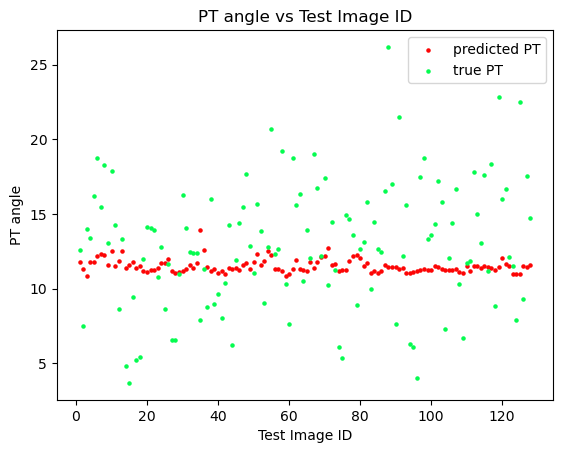

In [41]:
# plot PT value
x = [img_idx for img_idx in range(1, len(PT_value)+1)]
predicted_pt = [item[0] for item in PT_value]
true_pt = [item[1] for item in PT_value]

plt.scatter(x, predicted_pt, label='predicted PT', color='#fc0505', s=5)
plt.scatter(x, true_pt, label='true PT', color='#05fc4f', s=5)
plt.xlabel('Test Image ID')
plt.ylabel('PT angle')
plt.title('PT angle vs Test Image ID')
plt.legend()
plt.show()

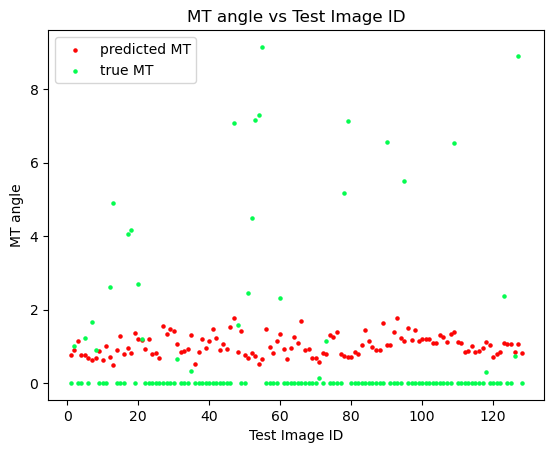

In [42]:
# plot MT value
x = [img_idx for img_idx in range(1, len(MT_value)+1)]
predicted_mt = [item[0] for item in MT_value]
true_mt = [item[1] for item in MT_value]

plt.scatter(x, predicted_mt, label='predicted MT', color='#fc0505', s=5)
plt.scatter(x, true_mt, label='true MT', color='#05fc4f', s=5)
plt.xlabel('Test Image ID')
plt.ylabel('MT angle')
plt.title('MT angle vs Test Image ID')
plt.legend()
plt.show()

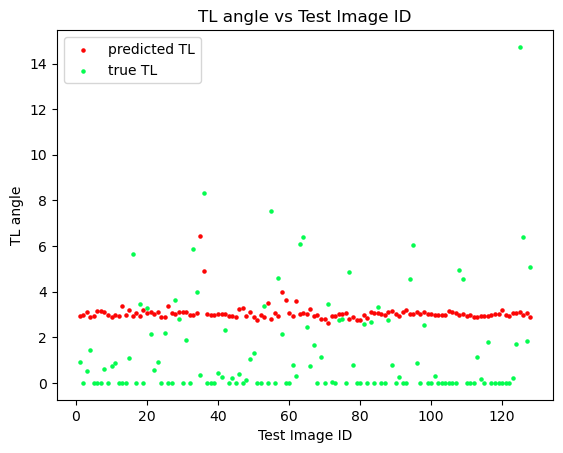

In [43]:
# plot TL value
x = [img_idx for img_idx in range(1, len(TL_value)+1)]
predicted_tl = [item[0] for item in TL_value]
true_tl = [item[1] for item in TL_value]

plt.scatter(x, predicted_tl, label='predicted TL', color='#fc0505', s=5)
plt.scatter(x, true_tl, label='true TL', color='#05fc4f', s=5)
plt.xlabel('Test Image ID')
plt.ylabel('TL angle')
plt.title('TL angle vs Test Image ID')
plt.legend()
plt.show()